In [1]:
import velvet as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
adata = sc.read_h5ad("../data/cellfiltered_adata.h5ad")
sdata = sc.read_h5ad("../data/cellfiltered_adata_splicing.h5ad")

In [3]:
sdata.layers['total'] = sdata.layers['spliced'] + sdata.layers['unspliced']

l = np.array(adata.layers['new'].sum(0)/adata.layers['total'].sum(0)).flatten()
s = np.array(sdata.layers['unspliced'].sum(0)/sdata.layers['total'].sum(0)).flatten()
t = np.array(list(l)+list(s))

df = pd.DataFrame({'Proportion "New"':t,
                   'Method':['Labelling']*len(l)+['Splicing']*len(s)}) 

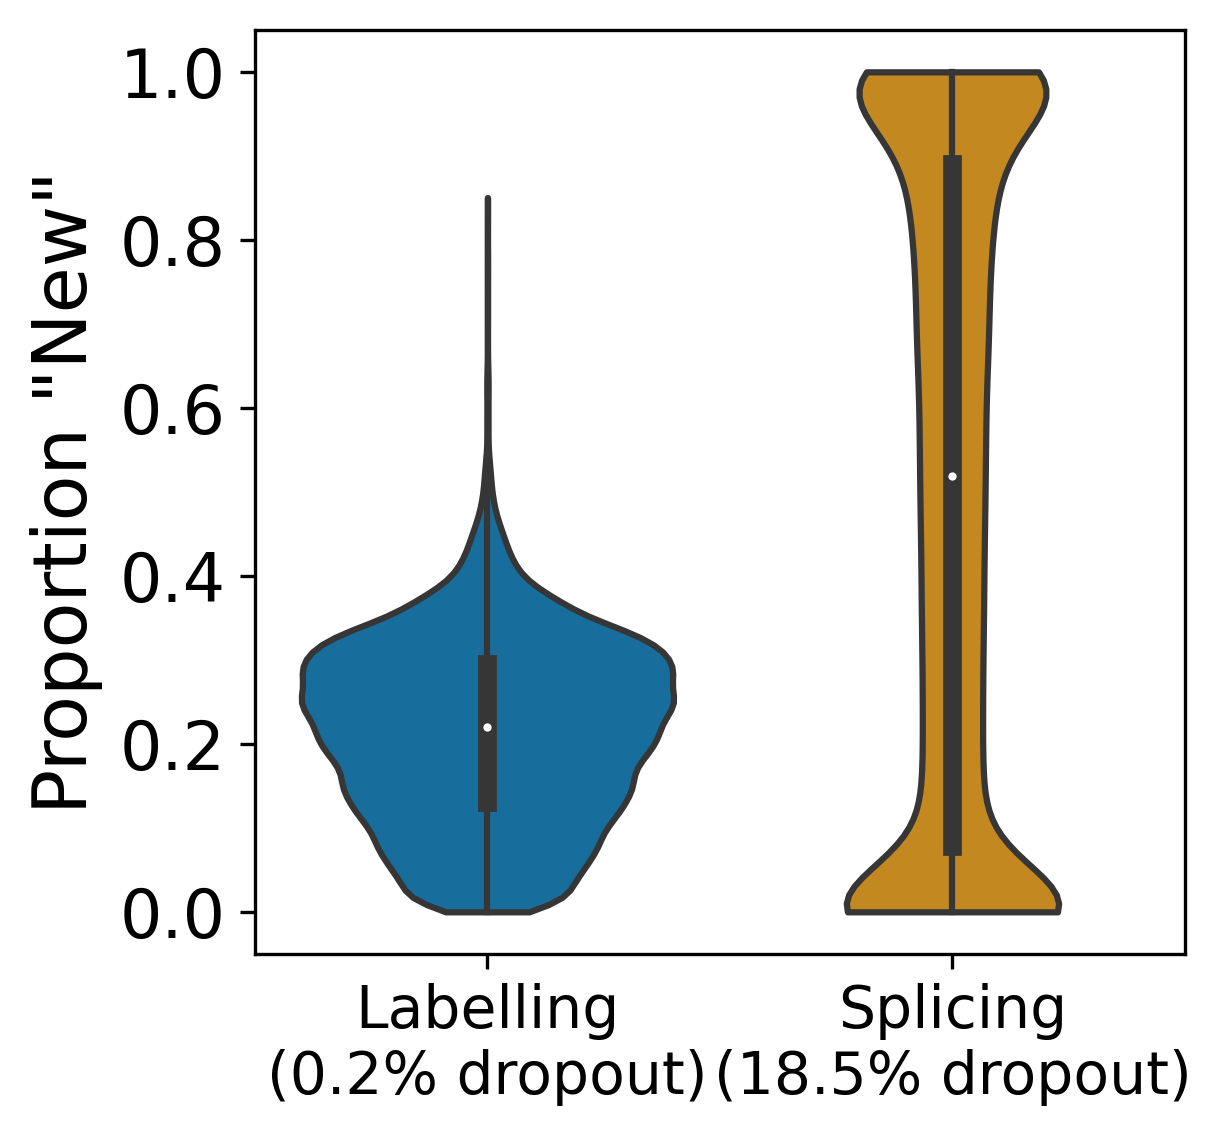

In [5]:
lp = 100*np.mean(l==0)
sp = 100*np.mean(s==0)
plt.figure(figsize=(4,4), dpi=300)
sns.violinplot(data=df, x='Method', split='Proportion "New"',y='Proportion "New"', orient='vertical', cut=0,
               palette=colpal.cmap_cat1)
plt.ylabel('Proportion "New"',fontsize=18)
plt.xticks([0,1], labels=[f'Labelling\n({lp:.1f}% dropout)',f'Splicing\n({sp:.1f}% dropout)'], fontsize=14)
plt.yticks(fontsize=16)
plt.xlabel("", fontsize=18)
for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig("../figures/1.1.0_splicing_overall_distributions.png", bbox_inches='tight')
plt.show()

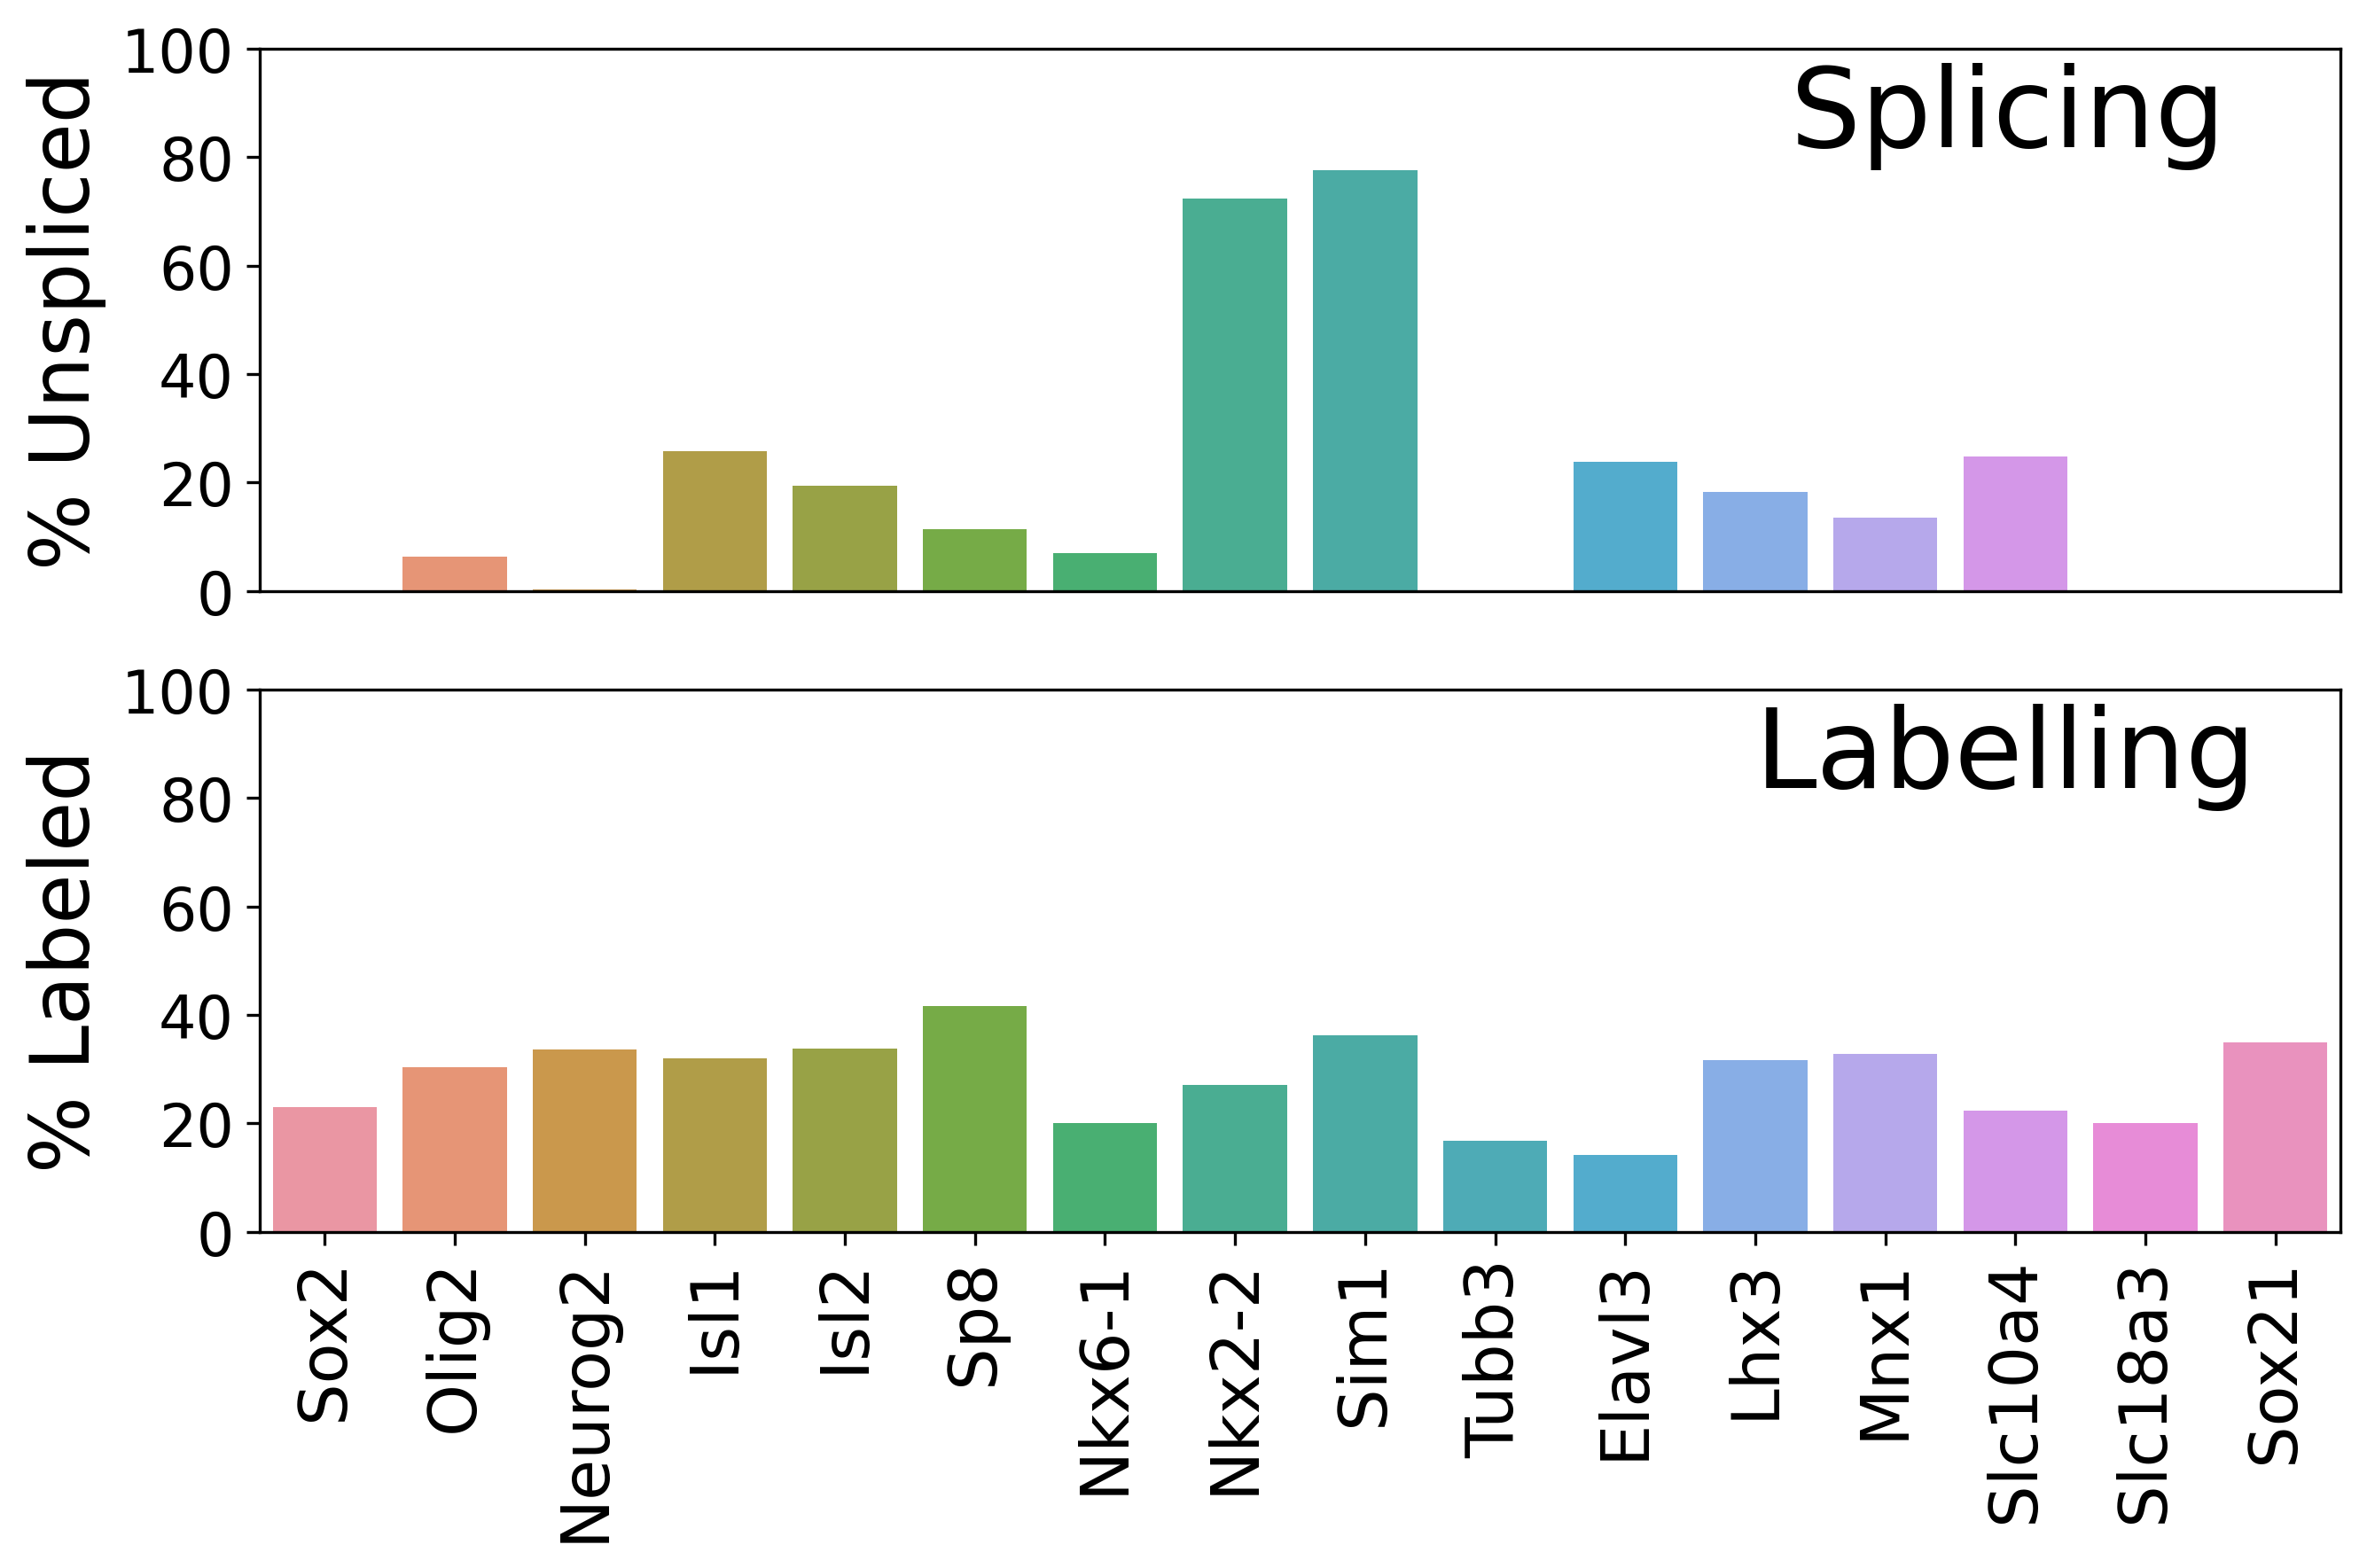

In [11]:
genes = ['Sox2','Olig2','Neurog2','Isl1','Isl2','Sp8','Nkx6-1',
         'Nkx2-2','Sim1','Tubb3','Elavl3','Lhx3','Mnx1','Slc10a4','Slc18a3','Sox21']

df = pd.DataFrame({'Gene':genes,
                   '% Unspliced':100*np.array(sdata[:,genes].layers['unspliced'].sum(0) /sdata[:,genes].layers['total'].sum(0)).flatten(),
                   '% Labeled':100*np.array(adata[:,genes].layers['new'].sum(0) / adata[:,genes].layers['total'].sum(0)).flatten()})

fig = plt.figure(figsize=(9,6), dpi=300)
ax1,ax2 = fig.subplots(2,1)
sns.barplot(data=df, x="Gene", y="% Unspliced", ax=ax1)
ax1.set_ylim((0,100))
ax1.set_xticks(ticks=[])
ax1.set_yticks(ticks=[0,20,40,60,80,100], labels=[0,20,40,60,80,100], fontsize=16)
ax1.set_xlabel('')
plt.text(11, 82, 'Labelling', fontsize=30)
ax1.set_ylabel("% Unspliced", fontsize=22)

sns.barplot(data=df, x="Gene", y="% Labeled", ax=ax2)
ax2.set_ylim((0,100))
ax2.set_xticks(ticks=np.arange(len(genes)), labels=genes, rotation=90, fontsize=18)
ax2.set_ylabel("% Labeled", fontsize=22)
ax2.set_xlabel('')
ax2.set_yticks(ticks=[0,20,40,60,80,100], labels=[0,20,40,60,80,100], fontsize=16)
ax1.text(11, 82, ' Splicing', fontsize=30)
plt.tight_layout()
for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/1.1.1_keygene_splicing_comparison.png', bbox_inches='tight')
plt.show()

# QC

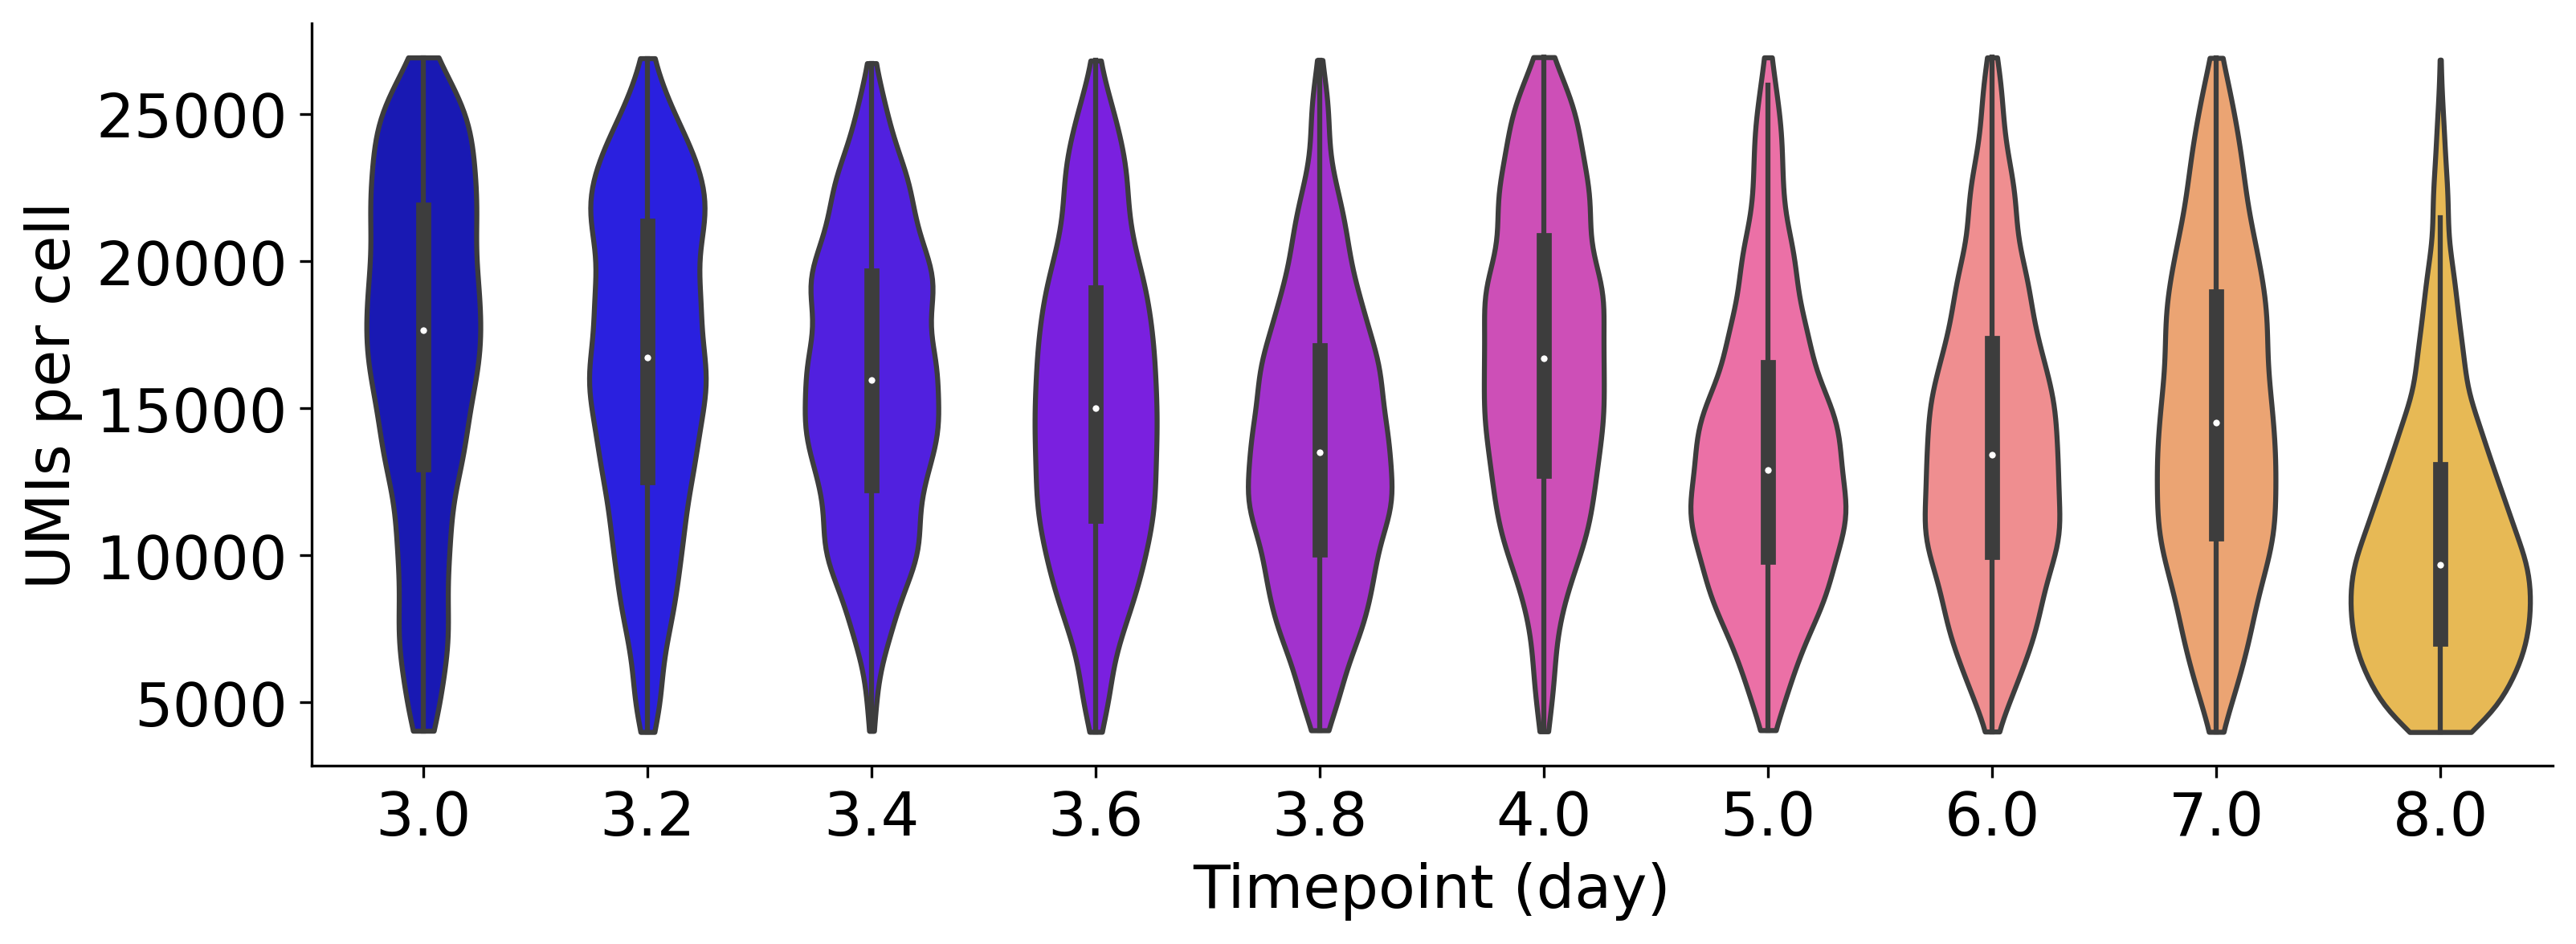

In [6]:
sizes = []
for tp in adata.obs.timepoint.unique():
    sizes.append(adata[adata.obs.timepoint == tp].shape[0])
x_size = min(sizes)

xs, ys = {}, {}
for tp in adata.obs.timepoint.unique():
    d = adata[adata.obs.timepoint == tp]
    x = np.array(d.layers['total'].sum(1)).flatten()
    x = np.random.choice(x, size=x_size)
    y = d.shape[0]
    xs[float(tp.replace('D',''))] = x
    ys[float(tp.replace('D',''))] = [y]
df1 = pd.DataFrame(xs)

plt.figure(figsize=(12,4), dpi=300)
sns.violinplot(x='variable', y='value', data=df1.melt(), cut=0, palette={float(v.replace('D','')):k for v,k in colpal.timepoint.items()})
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Timepoint (day)", fontsize=18)
plt.ylabel("UMIs per cell", fontsize=18)
for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/1.1.2_timepoint_UMIs.png', bbox_inches='tight')
plt.show()

In [7]:
df2 = pd.DataFrame(ys)

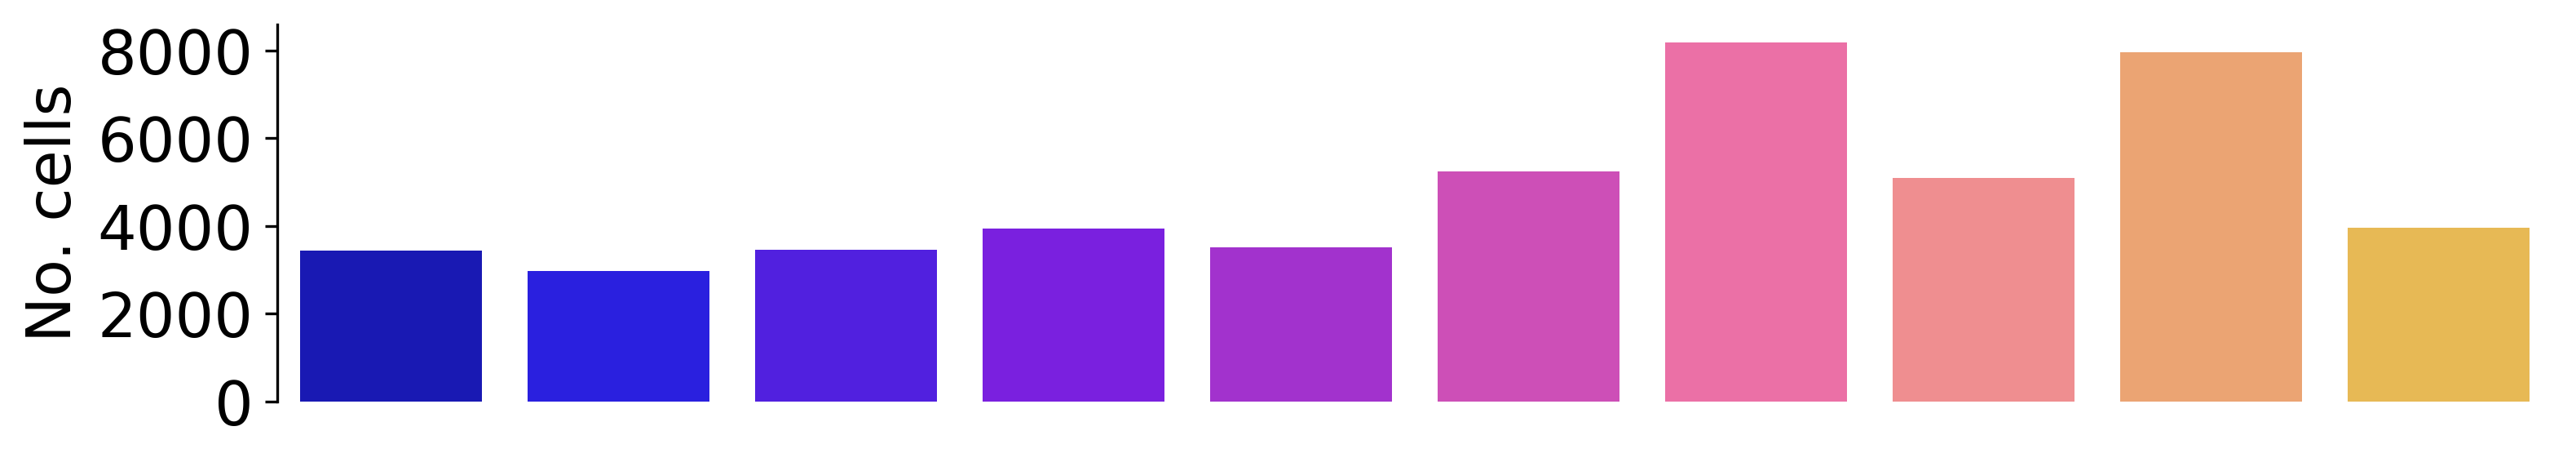

In [8]:
plt.figure(figsize=(12,2), dpi=300)
sns.barplot(x='variable', y='value', data=df2.melt(), palette={float(v.replace('D','')):k for v,k in colpal.timepoint.items()})
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])
plt.xlabel('')
plt.ylabel("No. cells", fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('../figures/1.1.3_timepoint_cells.png', bbox_inches='tight')
plt.show()

In [9]:
sizes = []
for tp in adata.obs.timepoint.unique():
    sizes.append(adata[adata.obs.timepoint == tp].shape[0])
x_size = min(sizes)

xs, ys = {}, {}
for rp in adata.obs.rep.unique():
    d = adata[adata.obs.rep == rp]
    x = np.array(d.layers['total'].sum(1)).flatten()
    x = np.random.choice(x, size=x_size)
    y = d.shape[0]
    xs[int(rp.replace('r',''))] = x
    ys[int(rp.replace('r',''))] = [y]


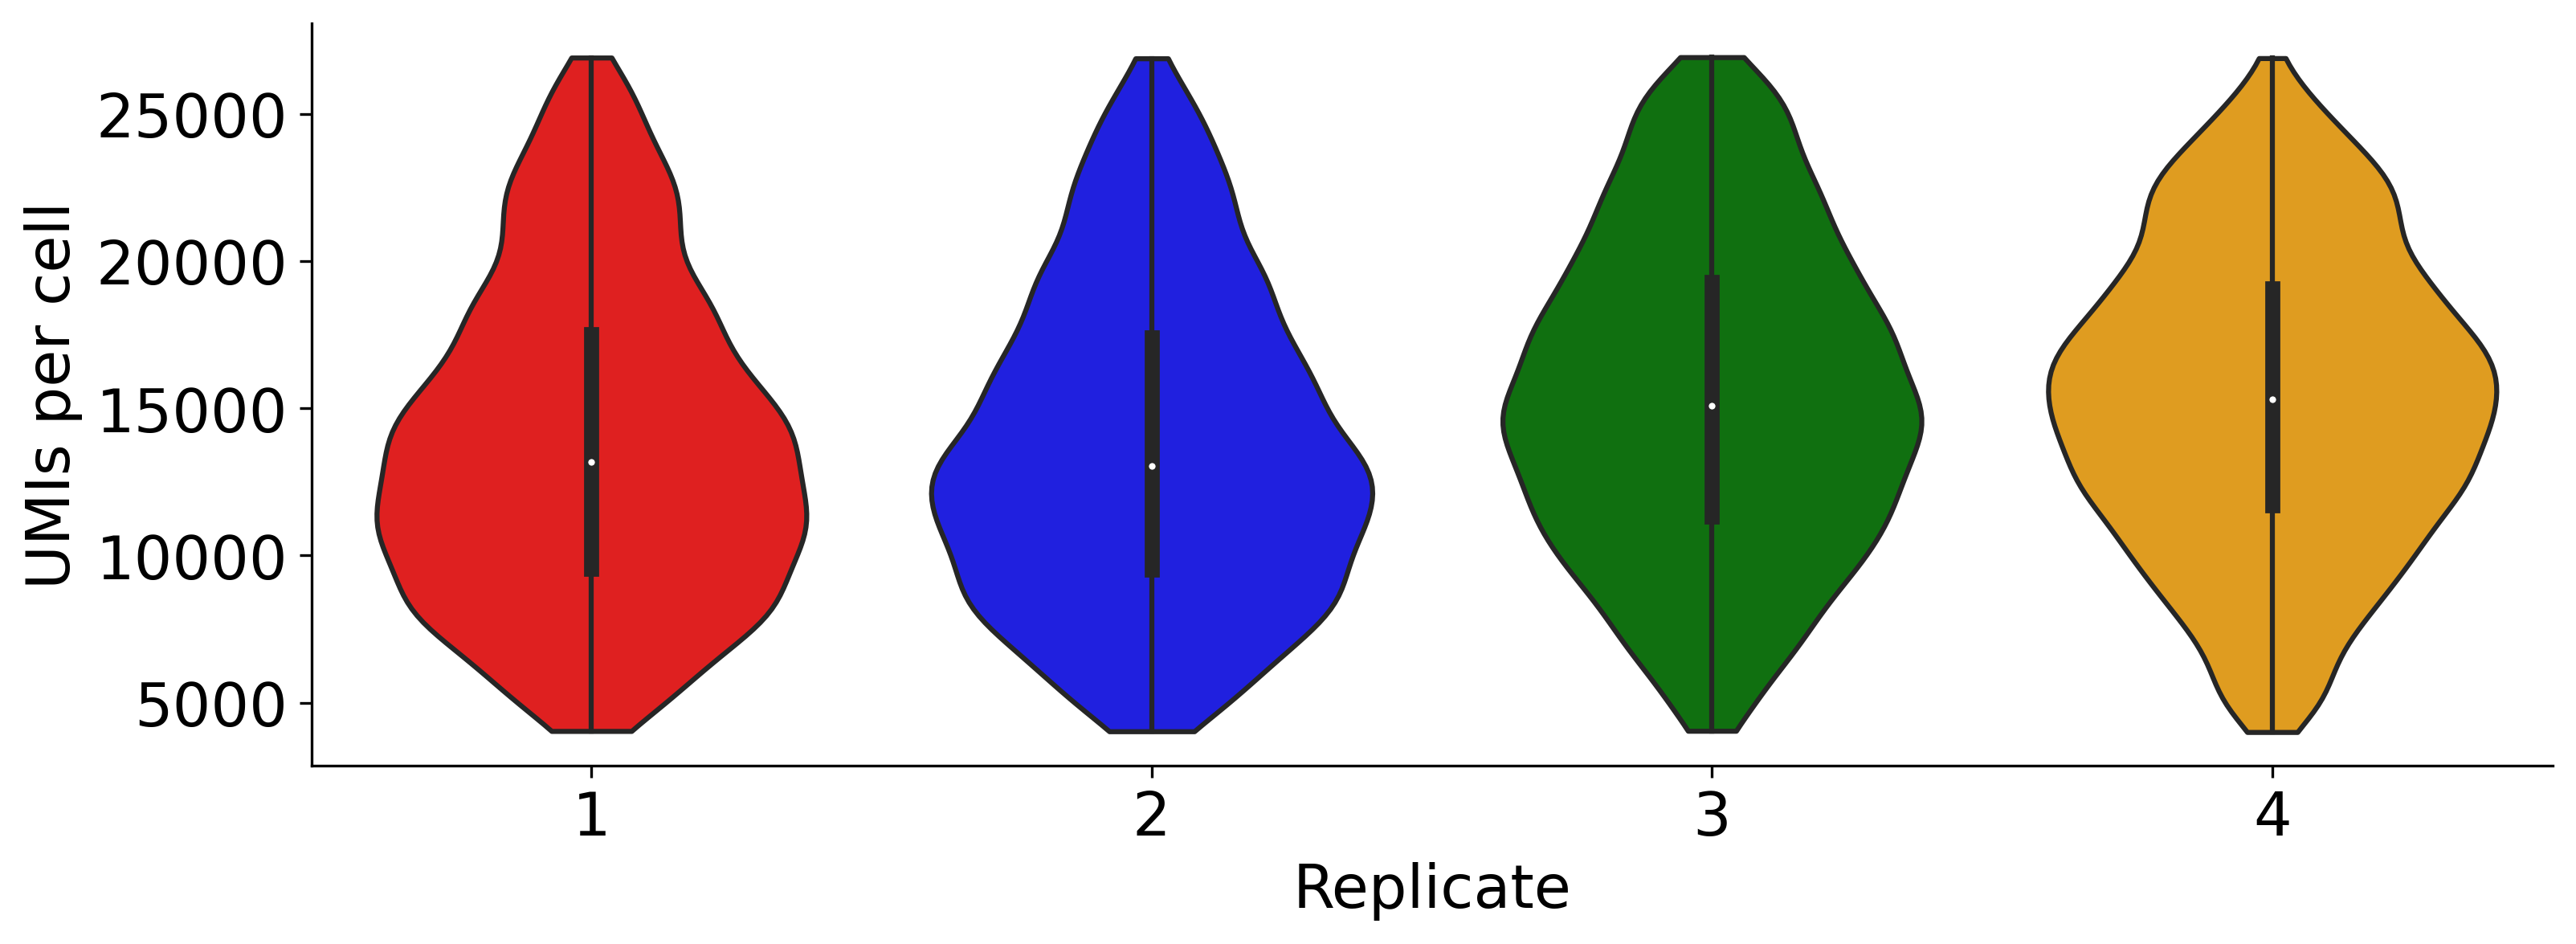

In [10]:
df3 = pd.DataFrame(xs)

plt.figure(figsize=(12,4), dpi=300)
sns.violinplot(x='variable', y='value', data=df3.melt(), cut=0, palette={float(v.replace('r','')):k for v,k in colpal.replicate.items()})
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Replicate", fontsize=18)
plt.ylabel("UMIs per cell", fontsize=18)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
plt.savefig('../figures/1.1.4_replicate_UMIs.png', bbox_inches='tight')
plt.show()

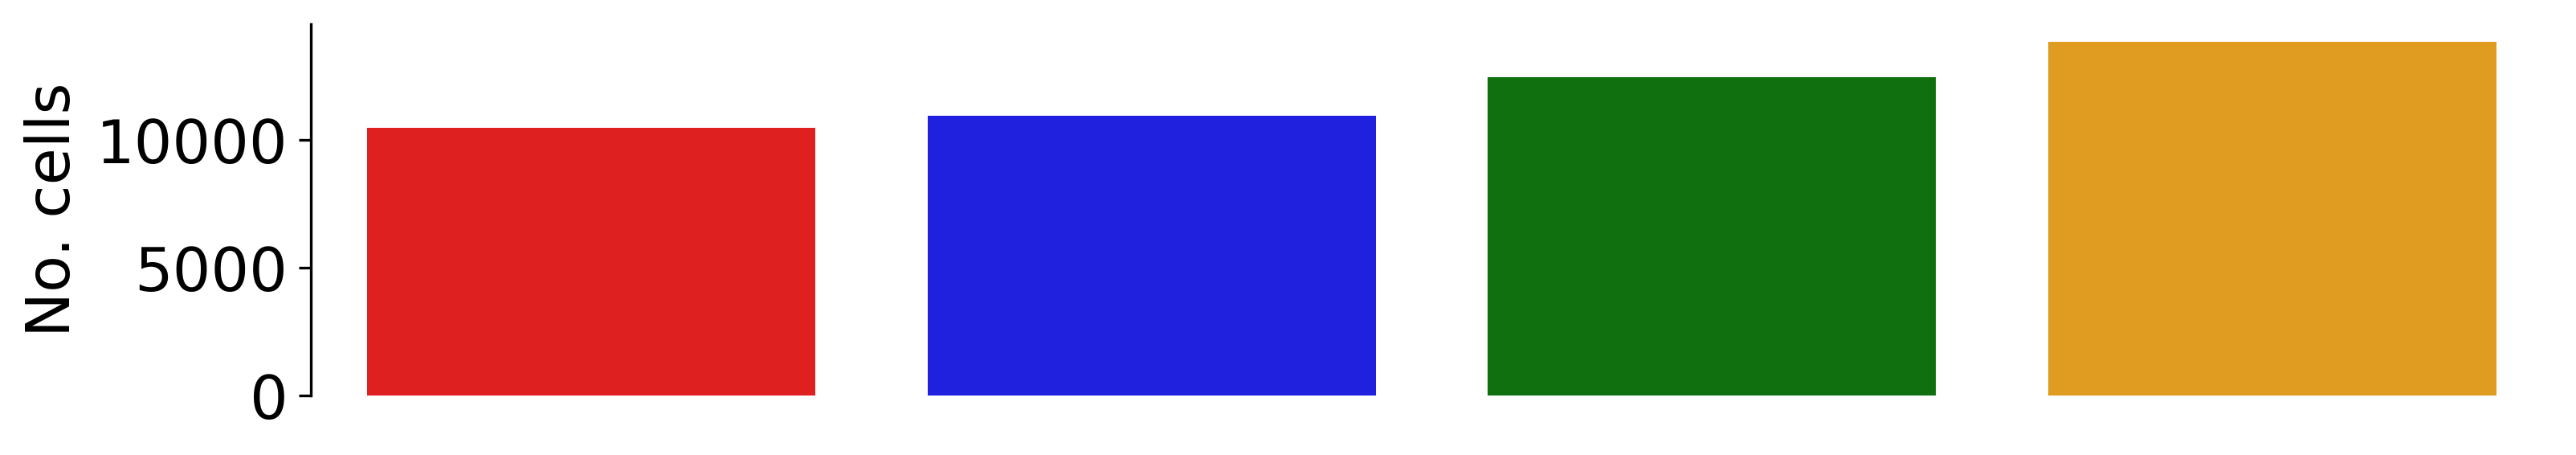

In [11]:
df4 = pd.DataFrame(ys)

plt.figure(figsize=(12,2), dpi=300)
sns.barplot(x='variable', y='value', data=df4.melt(), palette={float(v.replace('r','')):k for v,k in colpal.replicate.items()})
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])
plt.xlabel('')
plt.ylabel("No. cells", fontsize=18)
plt.yticks(fontsize=18)
for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

plt.savefig('../figures/1.1.5_replicate_cells.png', bbox_inches='tight')
plt.show()

# batch effect

In [4]:
adata = sc.read_h5ad("../data/cellfiltered_adata.h5ad")

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=5000)

adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata, svd_solver='arpack')

In [5]:
print("ready")

ready


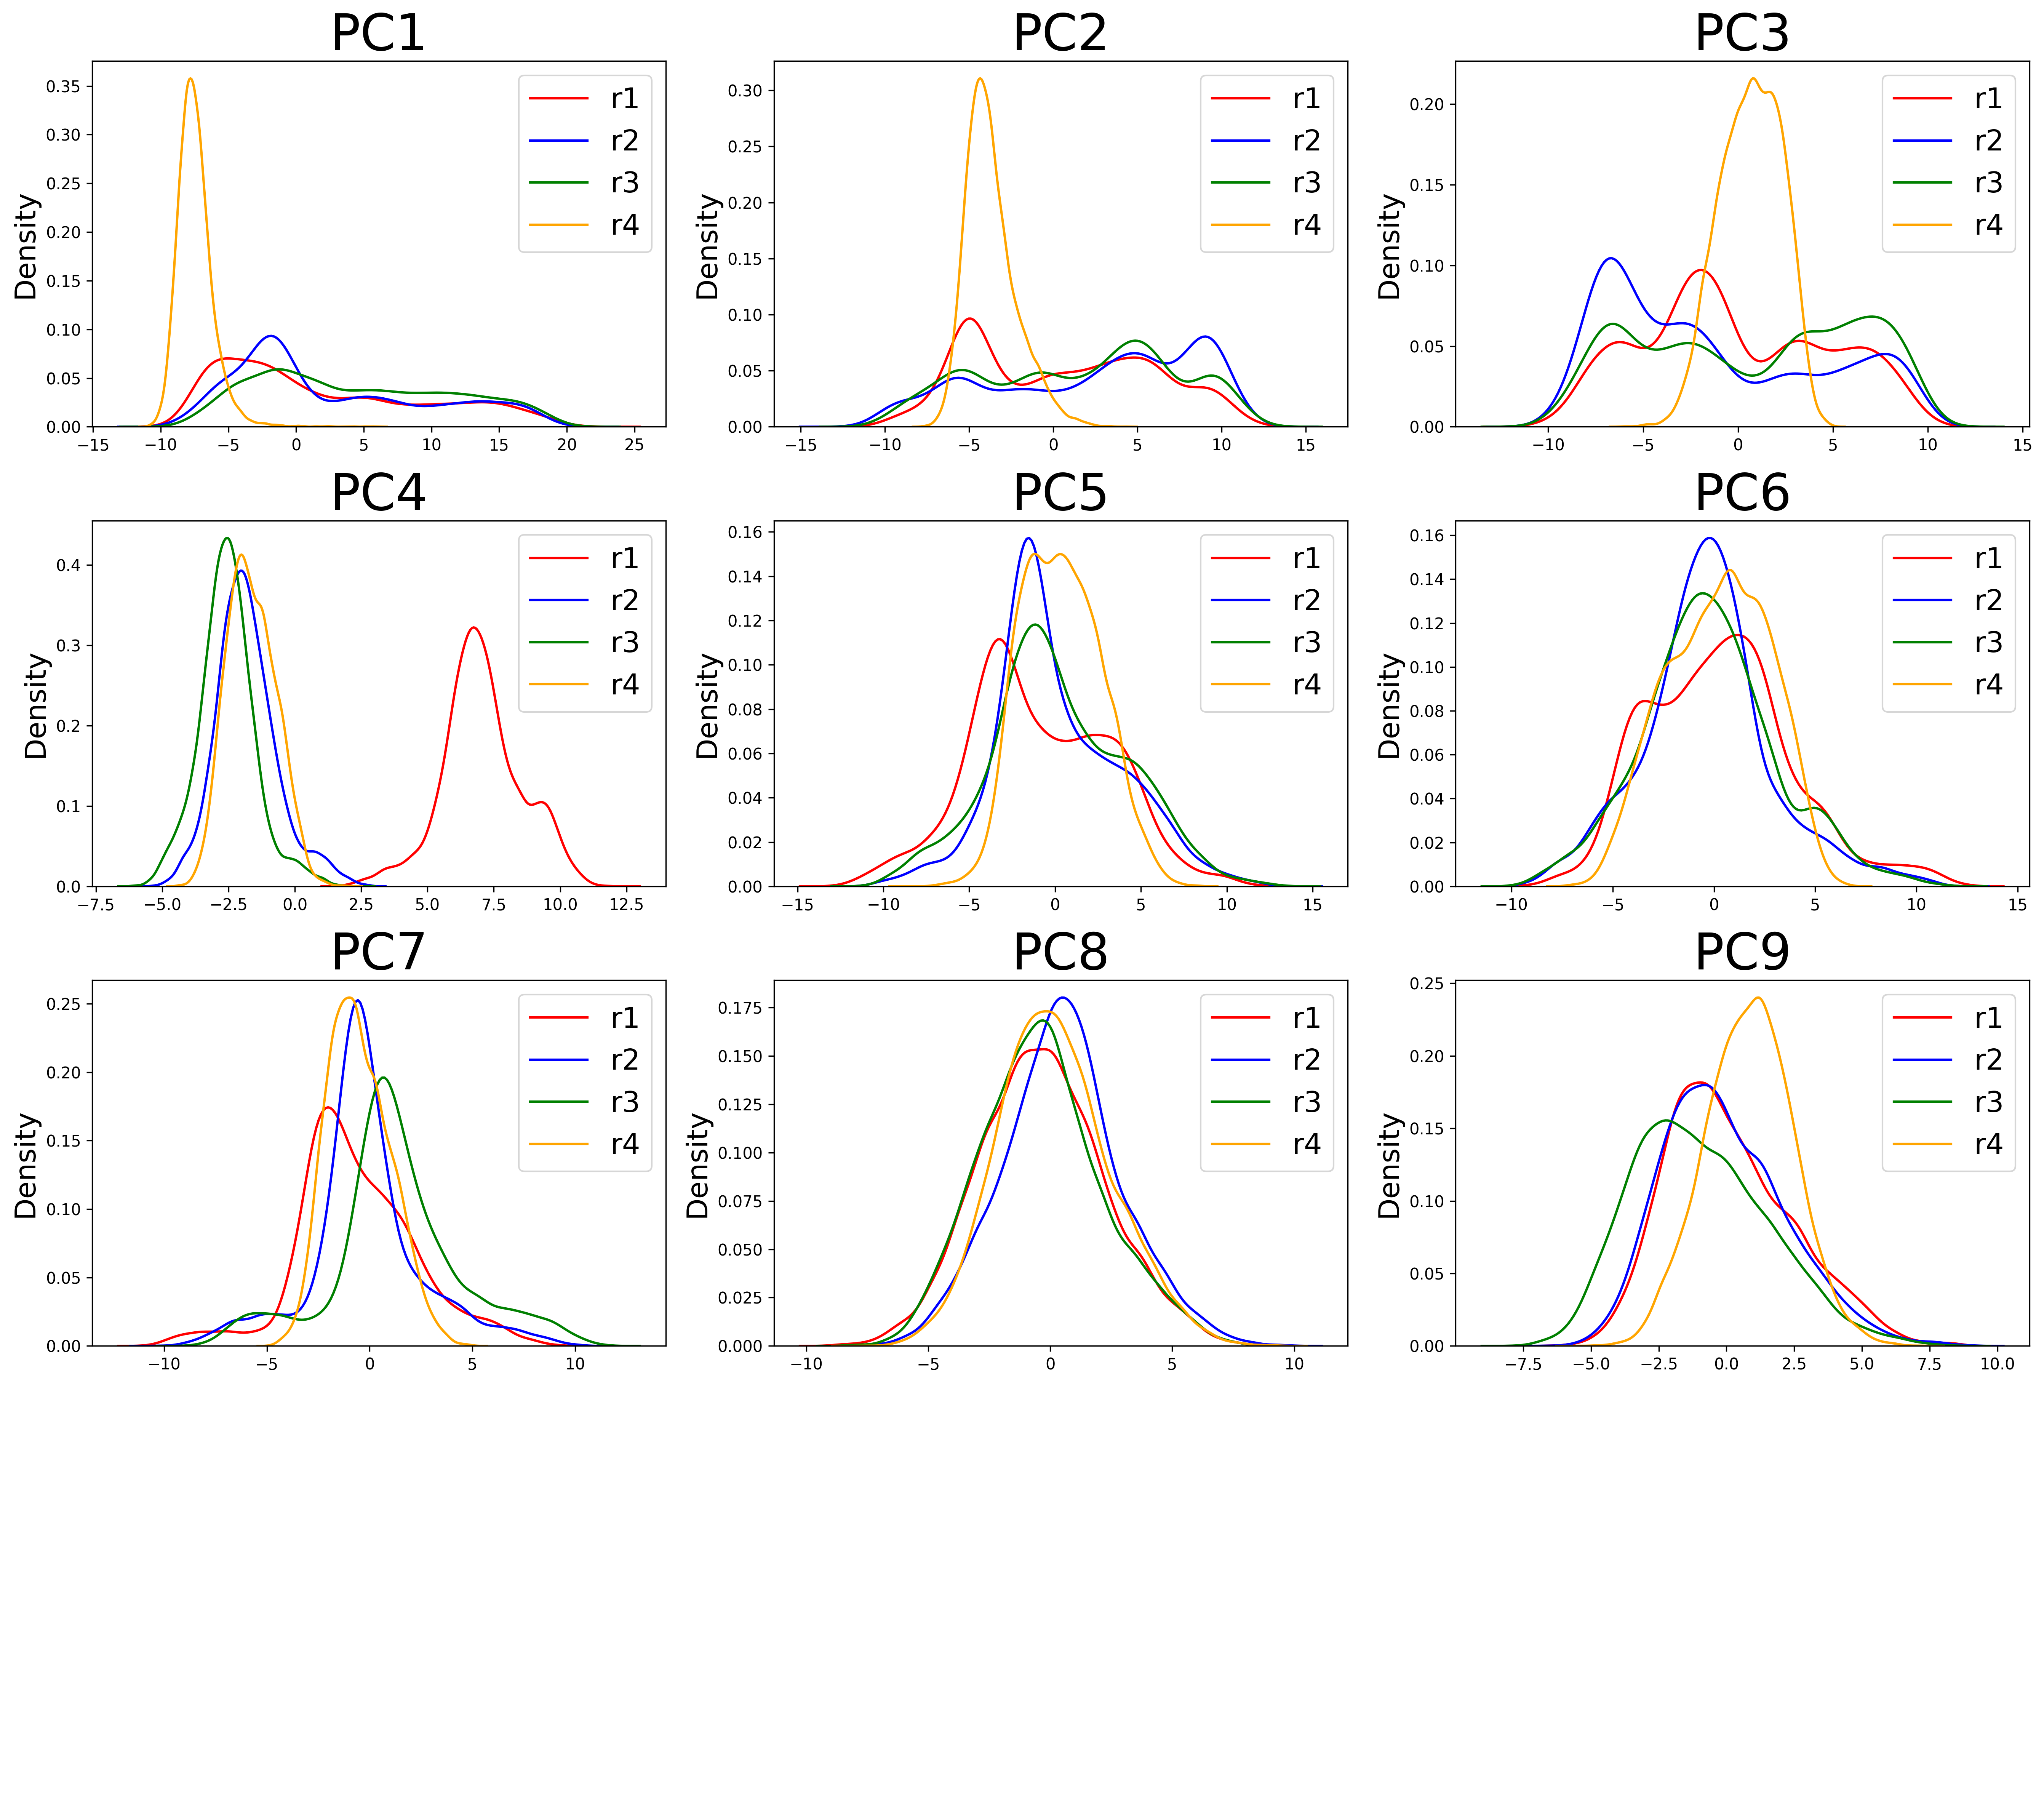

In [8]:
fig, axes = vt.pl.create_subplots(n_subplots=9, dpi=300)

for i, ax in enumerate(axes):
    sns.kdeplot(adata.obsm['X_pca'][:,i][adata.obs.rep=='r1'], ax=ax,
                color=list(colpal.replicate.values())[0], label='r1')
    sns.kdeplot(adata.obsm['X_pca'][:,i][adata.obs.rep=='r2'], ax=ax,
                color=list(colpal.replicate.values())[1], label='r2')
    sns.kdeplot(adata.obsm['X_pca'][:,i][adata.obs.rep=='r3'], ax=ax,
                color=list(colpal.replicate.values())[2], label='r3')
    sns.kdeplot(adata.obsm['X_pca'][:,i][adata.obs.rep=='r4'], ax=ax,
                color=list(colpal.replicate.values())[3], label='r4')
    ax.set_title(f"PC{i+1}", fontsize=32)
    ax.legend(fontsize=18)
    ax.set_ylabel("Density", fontsize=18)
for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
plt.tight_layout()
    
plt.savefig("../figures/1.1.6_PCs_without_stratifying.png", bbox_inches='tight')
plt.show()

In [9]:
adata = sc.read_h5ad("../data/cellfiltered_adata.h5ad")

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

genes = vt.pp.select_genes(
    adata[adata.obs.rep!='r4'], 
    n_variable_genes=5000,
    stratify_obs='rep'
)

adata = adata[:, list(genes)]
sc.tl.pca(adata, svd_solver='arpack')

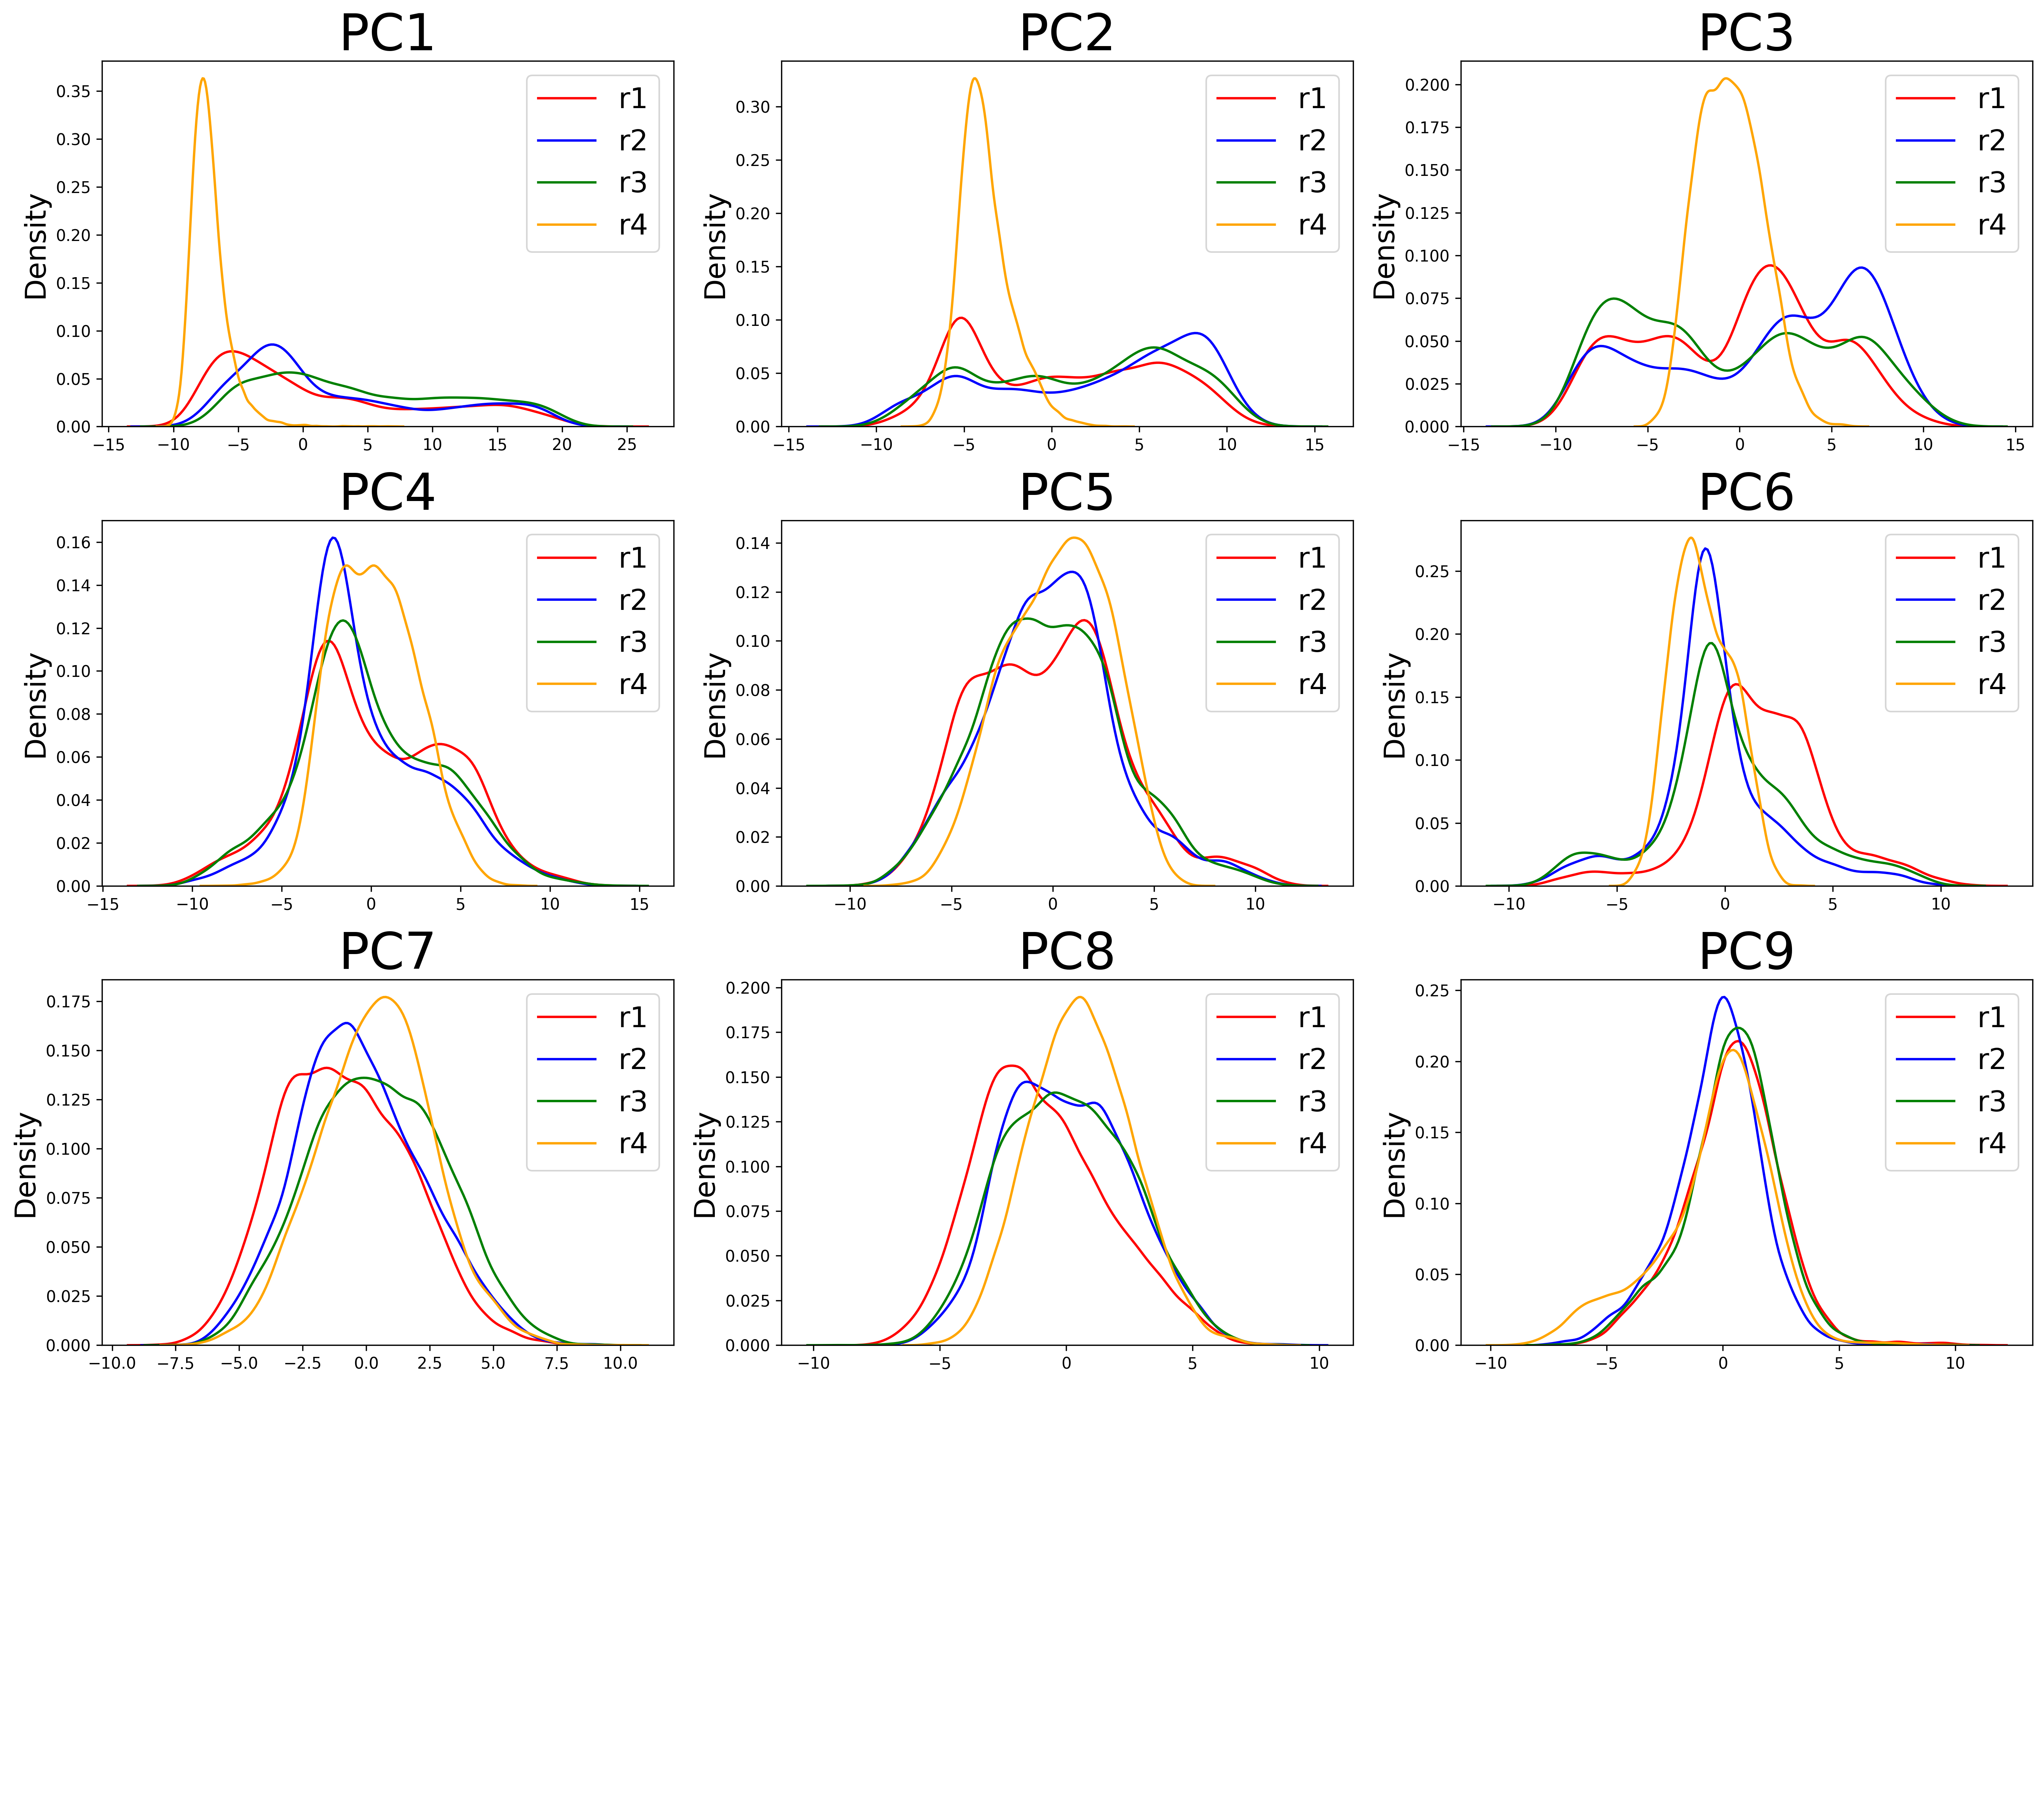

In [11]:
fig, axes = vt.pl.create_subplots(n_subplots=9, dpi=300)

for i, ax in enumerate(axes):
    sns.kdeplot(adata.obsm['X_pca'][:,i][adata.obs.rep=='r1'], ax=ax,
                color=list(colpal.replicate.values())[0], label='r1')
    sns.kdeplot(adata.obsm['X_pca'][:,i][adata.obs.rep=='r2'], ax=ax,
                color=list(colpal.replicate.values())[1], label='r2')
    sns.kdeplot(adata.obsm['X_pca'][:,i][adata.obs.rep=='r3'], ax=ax,
                color=list(colpal.replicate.values())[2], label='r3')
    sns.kdeplot(adata.obsm['X_pca'][:,i][adata.obs.rep=='r4'], ax=ax,
                color=list(colpal.replicate.values())[3], label='r4')
    ax.set_title(f"PC{i+1}", fontsize=32)
    ax.legend(fontsize=18)
    ax.set_ylabel("Density", fontsize=18)
    
for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
        
plt.tight_layout()

plt.savefig("../figures/1.1.7_PCs_with_stratifying.png", bbox_inches='tight')
plt.show()